## **Legal Agentic Workflow** : LangGraph

International students in Spain often face a fragmented landscape of information when exploring their options after graduation. While some resources are available across public websites, others are confined to internal university networks, making it difficult for students to access timely, accurate, and complete guidance.

To address this challenge, I’ve developed an agentic workflow that consolidates information from two key sources:

- Official web-based government policies (via web search tools), and
- University-specific internal documents (via Retrieval-Augmented Generation, or RAG)

<br>

The system is designed to provide students with clear, coherent, and context-aware answers. Importantly, the agent is also equipped with a query classification layer, ensuring that it responds only to questions relevant to international students in Spain. Any unrelated queries are politely declined, preserving the focus and accuracy of the assistant.

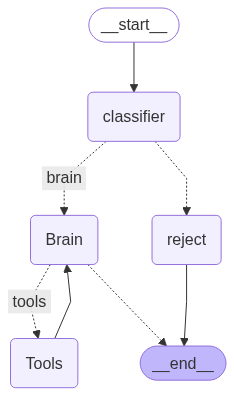

**Table of Contents** :

- Installing Dependancies
- Environment Setup
- Initialising the LLM
- Defining Web Search Tools
- Defining RAG Tool
- Combining Tools
- Defining the Nodes
- Building the Graph
- Testing

### **Installing Dependancies**

In [30]:
!pip install -U langgraph langsmith langchain-google-genai
!pip install langchain-tavily
!pip install langchain_community
!pip install google-search-results
!pip install pypdf
!pip install tiktoken
!pip install chromadb
!pip install langchain-chroma
!pip install unstructured
!pip install pdfminer.six
!pip install pi-heif
!pip install "unstructured[local-inference]"

### **Environment Setup**

In [1]:
from typing import Annotated

from langchain.chat_models import init_chat_model
from typing_extensions import TypedDict

from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
import os
import getpass
from langchain_tavily import TavilySearch
from langchain_community.utilities import SerpAPIWrapper
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.tools import Tool

from unstructured.partition.pdf import partition_pdf
from langchain_community.document_loaders import UnstructuredPDFLoader
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_google_genai import GoogleGenerativeAIEmbeddings
from langchain_chroma import Chroma
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import SystemMessage, HumanMessage, AIMessage

In [2]:
#defining the state class
class State(TypedDict):
  messages : Annotated[list, add_messages]

#initialising the Workflow Builder
graph_builder = StateGraph(State)

### **Initialising LLM**

In [3]:
if "GOOGLE_API_KEY" not in os.environ:
    os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter your Google AI API key: ")

#initialising the LLM
llm = init_chat_model("google_genai:gemini-2.0-flash", temperature=0.1) #smaller temperature value used to ensure that we get the most objective answers from the LLM (highest probability)

Enter your Google AI API key: ··········


### **Defining Web Search Tools**
Two Web Search Tools are defined - Tavily Search and Serp API, both work equally well in sourcing information. The distinction, however, lies in the convenience of deployment where Serp API requires a custom Tool to be defined unlike Tavily Search which can be direcly bound with the LLM.

In [4]:
if "TAVILY_API_KEY" not in os.environ:
  os.environ["TAVILY_API_KEY"] = getpass.getpass("Enter Tavily API Key:")

Enter Tavily API Key:··········


In [ ]:
search_tool = TavilySearch(max_results=1)
search_tool.invoke("what is normalisation in machine learning")

{'query': 'what is normalisation in machine learning',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://www.deepchecks.com/glossary/normalization-in-machine-learning/',
   'title': 'What is Normalization in Machine Learning? Techniques & Uses',
   'content': 'Normalization in machine learning is the process of translating data into the range [0, 1] (or any other range) or simply transforming data onto the unit',
   'score': 0.9404462,
   'raw_content': None}],
 'response_time': 1.21}

In [4]:
if "SERPAPI_API_KEY" not in os.environ:
  os.environ["SERPAPI_API_KEY"] = getpass.getpass("Enter Serp API Key:")

Enter Serp API Key:··········


In [6]:
search = SerpAPIWrapper(params={"engine":"google"})
search.run("what is normalisation in machine learning")

"['In machine learning, normalization is a statistical technique with various applications. There are two main forms of normalization, namely data normalization and activation normalization.', 'Normalization type: Machine learning.', 'Normalization entity_type: kp3_verticals.', 'Normalization kgmid: /g/11y8rhmzzs.', 'Normalization is an essential step in the preprocessing of data for machine learning models, and it is a feature scaling technique.', 'Normalization is a specific form of feature scaling that transforms the range of features to a standard scale.', 'Normalization in machine learning is the process of translating data into the range [0, 1] (or any other range) or simply transforming data onto the unit ...', 'The goal of normalization is to transform features to be on a similar scale. For example, consider the following two features:', 'In machine learning, normalization is a statistical technique with various applications. There are two main forms of normalization, namely da

In [7]:
#creating a custom tool to pass SerpAPI as a tool to the agent since it can't be directly used like Tavily API
web_search = Tool(
    name="web_search",
    description="Search the web for information about international student life, visa requirements, universities, and living conditions in Spain",
    func=search.run,
)

### **Defining RAG Tool**

In [ ]:
#Loading & Chunking the document

loader = UnstructuredPDFLoader("sample_doc.pdf")
doc = loader.load()

splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=100)
chunks = splitter.split_documents(doc)

In [9]:
#defining the embedding model, vector database & retriever
embeddings_model = GoogleGenerativeAIEmbeddings(model="models/embedding-001")
vector_db = Chroma.from_documents(chunks, embeddings_model)
retriever = vector_db.as_retriever()

In [10]:
#defining the RAG pipeline
template = """Answer the question based only on the following context:

{context}

Question: {question}
"""
prompt = ChatPromptTemplate.from_template(template)
model = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

#defining a function to combine the retrived document objects (chunks) for every query
def format_docs(docs):
    return "\n\n".join([d.page_content for d in docs])


chain = (
    {"context": retriever | format_docs, "question": RunnablePassthrough()}
    | prompt
    | model
    | StrOutputParser()
)

In [11]:
#creating a custom Tool that can be called by the LLM
rag_tool = Tool(
    name="rag_tool",
    description="Used to extract specific information related to IE University",
    func=chain.invoke
)

### **Combining Tools**

In [12]:
tools = [web_search, rag_tool]

In [13]:
#binding the tools with LLM so that it is aware of the available functionalities that it can call for more info
llm_with_tools = llm.bind_tools(tools)

### **Defining the Nodes**

In [14]:
#defining a classifier LLM to make sure that the input query is only related to international students in Spain

def classifier(state):
    question = next((msg.content for msg in reversed(state["messages"]) if msg.type == "human"), "")

    response = llm.invoke([
        SystemMessage(content="Answer YES if this is about international students in Spain. Otherwise say NO."),
        HumanMessage(content=question)
    ])

    if "yes" in response.content.lower():
        return state

    else:
        return {
            "messages": state["messages"] + [AIMessage(content="Sorry, I can only help with questions about international students in Spain or the EU.")]
        }


In [15]:
def workflow_brain(state: State):
  return {"messages" : [llm_with_tools.invoke(state['messages'])]}

In [16]:
tool_node = ToolNode(tools)

In [17]:
#function to aid conditional edge
def route_based_on_scope(state: State) -> str:
    return "brain" if classifier(state) else "reject"

### **Building the Graph**

In [18]:
#adding in-memory functionality for multi-turn conversations
memory = MemorySaver()

In [19]:
graph_builder.add_node("classifier", classifier)
graph_builder.add_node("Brain", workflow_brain)
graph_builder.add_node("Tools", tool_node)

#reject node to output a polite message if irrelevant queries are asked
graph_builder.add_node("reject", lambda state: {
    "messages": state["messages"] + [
        AIMessage(content="Sorry, I only answer questions related to international students in Spain or the EU.")
    ],
    "input": ""
})

In [20]:
graph_builder.add_edge(START, "classifier")

graph_builder.add_conditional_edges("classifier", route_based_on_scope, {
    "brain": "Brain",
    "reject": "reject"
})

graph_builder.add_conditional_edges("Brain", tools_condition, {"tools": "Tools", "__end__": END})
graph_builder.add_edge("Tools", "Brain")

graph_builder.add_edge("reject", END)

In [21]:
graph = graph_builder.compile(checkpointer=memory)

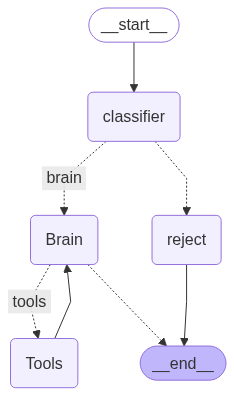

In [22]:
from IPython.display import Image, display
display(Image(graph.get_graph().draw_mermaid_png()))

### **Testing**

In [57]:
config = {"configurable": {"thread_id": "1"}}

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config=config):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)

    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: hi my name is nitin
Assistant: Hello Nitin, how can I help you today?
User: how many hours can international students work in spain
Assistant: 
Assistant: ['If you have a student visa, you are allowed to work up to 30 hours a week. The student visa authorizes you to work in Spain with 2 fundamental conditions.', 'The student visa DOES allow you to work in Spain, and does so up to 30 hours per week. Generally speaking, there are 2 legal options that will allow any foreign ...', 'Spain offers several opportunities for work to international students. Spain allows its students to work on a student visa up to 30 hours per week. After ...', 'For 30 hours a week as a student you can find some work as a waiter, or store cashier (dependiente). Very low paid and Spanish is a most... So ...', 'Full-time program (minimum of 20 hours per week) at an authorized post-compulsory secondary education center in Spain, leading to the obtaining ...', 'International students can legally work for up to

In [24]:
#testing with irrelevant questions

def stream_graph_updates(user_input: str):
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}, config=config):
        for value in event.values():
            print("Assistant:", value["messages"][-1].content)

while True:
    try:
        user_input = input("User: ")
        if user_input.lower() in ["quit", "exit", "q"]:
            print("Goodbye!")
            break

        stream_graph_updates(user_input)

    except:
        # fallback if input() is not available
        user_input = "What do you know about LangGraph?"
        print("User: " + user_input)
        stream_graph_updates(user_input)
        break

User: how many teams play in the FIFA world cup
Assistant: Sorry, I can only help with questions about international students in Spain or the EU.
Assistant: 
User: exit
Goodbye!
